In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

In [18]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[1])}")


Length of the first datax array: 678


In [19]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)


[0.2, 0.25, 0.25, 0.2, 0.25, 0.2]


In [20]:
# dt and mag data

mag = (1.49972905, 7.42332916, -11.5028191, -4.07344553, -3.28229147, 3.14782126, 3.57746724)
dt = [0.0, 88594.90558064939, 91797.85200701188, 91896.81383935199, 92121.65322824288, 92551.52745506703, 93534.55033071572]

In [21]:
# set up the class

cluster = ClusterLensing_fyp(datax_list, datay_list, data_psi_list, 0.5, 1, pixscale_list, diff_z=False)


In [22]:
# check with the lenstronomy package directly
realsize = 878
grid = np.linspace(0, realsize-1, realsize)
grid = grid * 0.25

lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [{'grid_interp_x': grid, 'grid_interp_y': grid, 'f_': data_psi_list[4],
                          'f_x': datax_list[4], 'f_y': datay_list[4]}]

lensModel_real = LensModel(lens_model_list=lens_model_list2)
# Use lens equation solver
solver2 = LensEquationSolver(lensModel_real)
coord = (125, 115)
img_po = solver2.image_position_from_source(coord[0], coord[1], kwargs_lens2, min_distance=0.25, search_window=100, verbose=False, x_center=110, y_center=110)
mag = lensModel_real.magnification(img_po[0], img_po[1], kwargs_lens2)
print(mag)

[ 1.02577077 -1.79748076 -1.7099096   2.27511712]


In [23]:
src_guess = (63.8, 84.1)
chi_sq = cluster.chi_squared(src_guess, dt, index = 1)
print(chi_sq)

0.0


In [24]:
# localization of images
x_approx, y_approx, chi_sq = cluster.localize_known_cluster(x_src_guess=75,y_src_guess=80,dt_true = dt, index = 1)
print(x_approx, y_approx, chi_sq)


76.92646534232253 76.75755285919587 625587016801.6982


In [13]:
print(len(datax_list[1]))

678


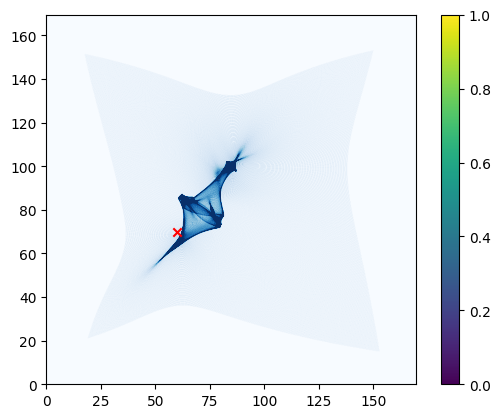

In [15]:
# look at the caustic
array_test = np.zeros((678,678))
datay = datay_list[1]/0.25
datax = datax_list[1]/0.25
for i in range(0,678):
    for j in range(0,678):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

plt.imshow(array_test, cmap='Blues', vmax = 20, extent=[0, 678*0.25, 678*0.25,0 ])
plt.scatter(60,70, c = 'r', marker='x')
plt.gca().invert_yaxis()
plt.colorbar()
